In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



```

Importing the libraries

In [ ]:
import pandas as pd
import time
import datetime
!pip install praw
import praw
import praw.exceptions
import numpy as np
from scipy.sparse import csr_matrix
import nltk
import matplotlib.pyplot as plt
import datetime
from datetime import date
import time
import pickle
import scipy
import scipy.sparse as sps
!pip install louvain
import louvain
import igraph as ig


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.9 MB/s eta 0:00:00


<ipython-input-2-48d300182c17>:18: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


Implementing Reddit API

In [ ]:
# Create a Reddit instance using the praw package.
reddit = praw.Reddit(
    client_id='CWJjVr1bEeH44Y5n86HcnA',
    client_secret='eT7xoyngTgl-9AlqoQO56nSakFuEig',
    user_agent='barbie_project',
    check_for_async=False
)

Data Extraction

In [ ]:
keyword = ["Feminism"]

# Search for subreddits related to the keyword
subreddits = reddit.subreddits.search(keyword, limit=100)
DF = pd.DataFrame(vars(subreddit) for subreddit in subreddits)
DF = DF[['display_name','subscribers']].sort_values(by='subscribers',ascending = False)

# show result
DF.dropna(inplace=True)
display(DF)
subreddits_name_list = list(DF['display_name'])


,display_name,subscribers
74,AskReddit,44961701.0
46,memes,29680073.0
12,TwoXChromosomes,13661656.0
41,unpopularopinion,4146851.0
62,changemyview,3595225.0
...,...,...
42,UncensoredFeminism,43.0
84,FeminismMiddleGround,41.0
87,FeminismInAction,30.0
75,Gynocentrism_feminism,29.0


In [ ]:
# Define a function to read posts from a specified subreddit.
def read_reddit(subreddit_name, total_posts_to_retrieve,
                time_filter, sort_mode, keywords, batch_size = 250):

    subreddit = reddit.subreddit(subreddit_name)
    all_posts = []
    retrieved_posts = 0
    current_batch = 0
    after_param = ''

    # Loop to read reddit posts in batches until the desired number of posts is retrieved.
    while retrieved_posts < total_posts_to_retrieve:
        remaining_posts = total_posts_to_retrieve - retrieved_posts
        posts_to_retrieve = min(remaining_posts, batch_size)
        collected_posts = list(subreddit.search(keywords,
                                                limit=posts_to_retrieve,
                                                time_filter=time_filter,
                                                sort=sort_mode,
                                                params={'after': after_param}))
        if not collected_posts: break
        all_posts.extend(collected_posts)
        retrieved_posts += len(collected_posts)
        current_batch += 1
        after_param = 't3_' + all_posts[-1].id

    df = pd.DataFrame(vars(post) for post in all_posts) # turn into dataframe
    print('a total of ' + str(len(df)) + ' posts have been collected out of '
                        + str(total_posts_to_retrieve))
    return df

In [ ]:
# Set search criteria for the Reddit API
total_posts_to_retrieve = 1000
time_filter = 'year' # "all", "day", "hour", "month", "week", or "year"
sort_mode = 'top' # "relevance", "hot", "top", "new", or "comments"
keywords = 'feminism'

dfs = []
# Iterate over each subreddit in the list
for subreddit_name in subreddits_name_list :
    print(subreddit_name)
    df = read_reddit(subreddit_name, total_posts_to_retrieve, time_filter,
                 sort_mode, keywords, batch_size=100)
    dfs.append(df)


# Merge all the collected dataframes into a single dataframe
final_df = pd.concat(dfs, ignore_index=True)

# Select specific columns of interest from the merged dataframe
final_df = final_df[['id','created','subreddit','title','selftext','author',
         'author_fullname','upvote_ratio','ups','num_comments']]

# Convert timestamp to a readable date format
final_df["created"] = [datetime.date.fromtimestamp(i) for i in final_df["created"]]

# Save the final dataframe to a CSV file
final_df.to_csv('drive/MyDrive/NetworkScience_Project/Reddit/feminism_reddit.csv', index=True)

# Display the final dataframe
display(final_df)

AskReddit
a total of 14 posts have been collected out of 1000
memes
a total of 9 posts have been collected out of 1000
TwoXChromosomes
a total of 190 posts have been collected out of 1000
unpopularopinion
a total of 4 posts have been collected out of 1000
changemyview
a total of 21 posts have been collected out of 1000
teenagers
a total of 83 posts have been collected out of 1000
Conservative
a total of 11 posts have been collected out of 1000
SubredditDrama
a total of 4 posts have been collected out of 1000
justneckbeardthings
a total of 41 posts have been collected out of 1000
TrollXChromosomes
a total of 17 posts have been collected out of 1000
NotHowGirlsWork
a total of 169 posts have been collected out of 1000
socialism
a total of 31 posts have been collected out of 1000
MensRights
a total of 218 posts have been collected out of 1000
IncelTears
a total of 50 posts have been collected out of 1000
TopMindsOfReddit
a total of 15 posts have been collected out of 1000
JordanPeterson
a 

,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments
0,111wg2e,2023-02-14,AskReddit,"Feminists of Reddit, What are some common misc...",,Limbuchai,t2_mszaao4e,0.76,4,6
1,11rvprt,2023-03-15,AskReddit,How do you honestly feel about feminism?,,Direct-Suit-5514,t2_urrt1bsy,0.67,4,111
2,14wo2z8,2023-07-11,AskReddit,What's the diference betwew toxic masculinity ...,,Poch1212,t2_134q8a5s,0.75,2,20
3,11ctnnr,2023-02-26,AskReddit,[Serious] What is feminism to you?,,6FeetDownUnder,t2_9nsnbrmn,1.00,2,5
4,157g9ox,2023-07-23,AskReddit,do you consider yourself a feminist and what d...,,traanniecum,t2_f4lajpcul,0.76,2,4
...,...,...,...,...,...,...,...,...,...,...
1904,13fckst,2023-05-12,Feminism4Everyone,Advice: Is r\feminism ran by a transphobe?,I just joined it & then saw the name of this o...,jbaraxk,t2_v984dykl,1.00,2,4
1905,17xgcjj,2023-11-17,FeminismMiddleGround,I'd like to vent about how some movements nega...,DISCLAIMER: I'm a leftist who's completely awa...,headlessfreak1592,t2_ecjr4r0r,1.00,1,0
1906,15156w2,2023-07-16,Gynocentrism_feminism,We have lots of information on gynocentrism an...,,rbrockway,t2_fbc84,1.00,3,0
1907,16d9pd1,2023-09-08,Gynocentrism_feminism,The Two Faces of Feminism: Grandiose and vulne...,,Imaginalis_,t2_rvysog43,1.00,3,1


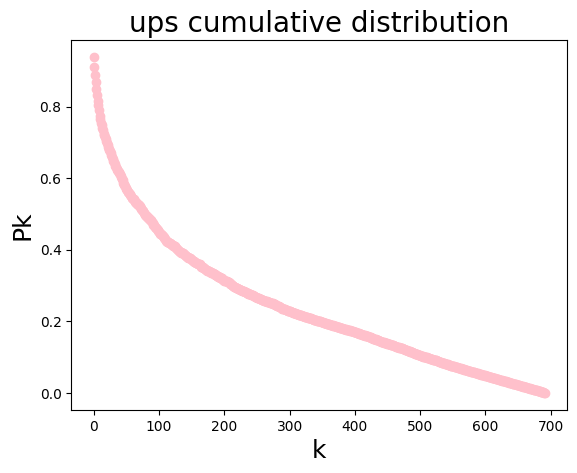

In [ ]:
# Plot ups distribution
import numpy as np
ups = np.squeeze(np.array(final_df["ups"]+1))
k = np.unique(ups)
pk = np.histogram(ups,k)[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(Pk,'o', color='pink')
plt.title("ups cumulative distribution", size=20)
plt.xlabel("k", size=18)
plt.ylabel("Pk", size=18)
plt.show()

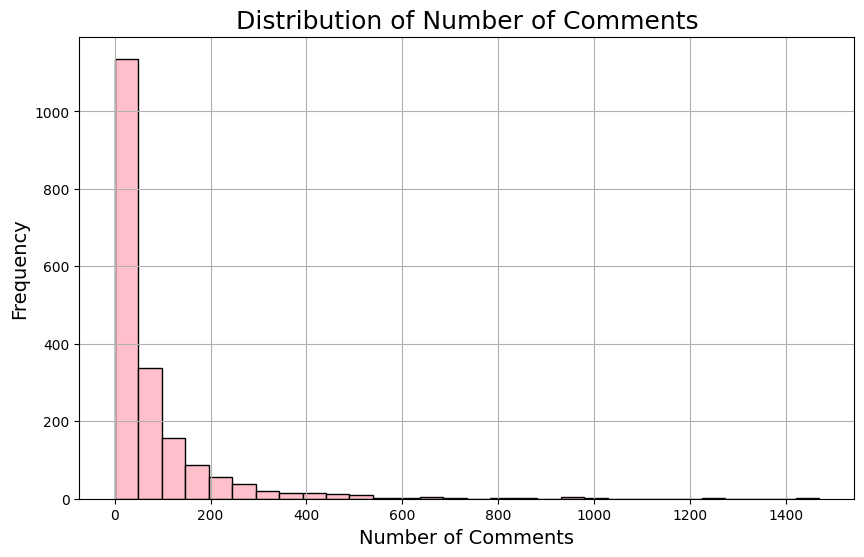

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(final_df["num_comments"], bins=30, color='pink', edgecolor='black')
plt.title("Distribution of Number of Comments", size=18)
plt.xlabel("Number of Comments", size=14)
plt.ylabel("Frequency", size=14)
plt.grid(True)
plt.show()


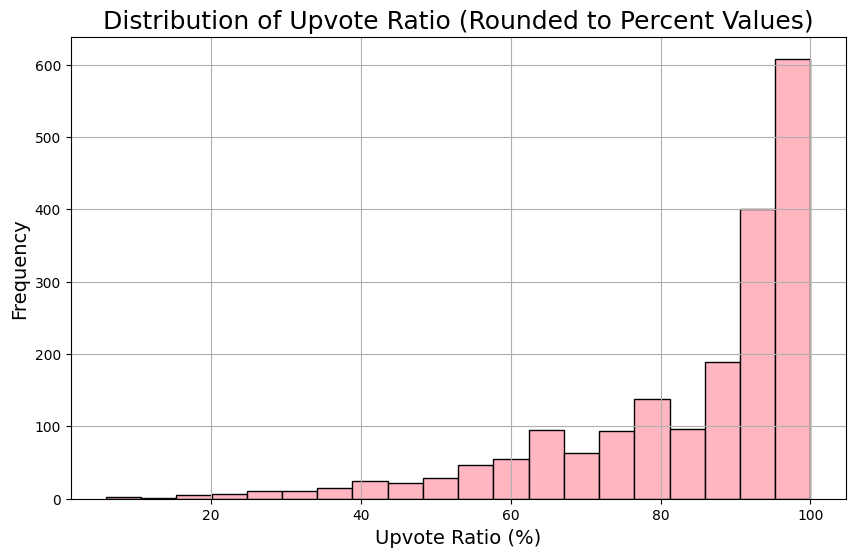

In [ ]:
# Rounding upvote ratio to percent values
final_df["upvote_ratio_percent"] = (final_df["upvote_ratio"] * 100).round()

# Plotting the distribution of the rounded upvote ratio
plt.figure(figsize=(10, 6))
plt.hist(final_df["upvote_ratio_percent"], bins=20, color='lightpink', edgecolor='black')
plt.title("Distribution of Upvote Ratio (Rounded to Percent Values)", size=18)
plt.xlabel("Upvote Ratio (%)", size=14)
plt.ylabel("Frequency", size=14)
plt.grid(True)
plt.show()

In [ ]:
# Filtering the dataframe, keeping the posts that have more than 200 ups
final_df_selected = final_df.copy()
final_df_selected = final_df_selected.loc[final_df_selected['ups'] >=200]
display(final_df_selected)

,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments,upvote_ratio_percent
14,119briz,2023-02-22,memes,Patriarchy 1 Feminism 0,,Bright-Repeat-4616,t2_d7iu3pvp,0.89,851,61,89.0
23,13coexf,2023-05-09,TwoXChromosomes,“We gave up not having to work for this?”,Is something I often see on anti-women’s right...,aliteralbagof_dicks,t2_b9ijx93x,0.92,8672,412,92.0
24,157ktz0,2023-07-23,TwoXChromosomes,To the men who understand feminism after seein...,Don’t post about it here. We know what issues ...,tiny_galaxies,t2_6h06qwsz,0.67,7996,1265,67.0
25,14hyykm,2023-06-24,TwoXChromosomes,"no, feminism is not the reason you have to wor...",I am so so tired of this talking point. Histor...,slow_____burn,t2_6xxa16wz,0.93,4317,247,93.0
26,1344ma8,2023-04-30,TwoXChromosomes,The rise of the whole ‘tradwife’ trend among y...,Just watched a Stacey Dooley documentary (I’m ...,withouthope17,t2_smx4gfg7,0.90,3884,504,90.0
...,...,...,...,...,...,...,...,...,...,...,...
1682,1ag69b9,2024-02-01,LeftWingMaleAdvocates,Gen Z boys and men more likely than baby boome...,,Fan_Service_3703,t2_s3sgfh6j,0.98,231,95,98.0
1683,10xqmz5,2023-02-09,LeftWingMaleAdvocates,problems for short men,This isn't the biggest issue but I still wante...,boomboxspence,t2_iz9ceobc,1.00,217,72,100.0
1684,12v5h63,2023-04-22,LeftWingMaleAdvocates,The struggle of being in trans spaces as a man,"So a lot of this space is cisgender, which is ...",Dungeon_Master_Lucky,t2_5lzcyree,0.93,217,101,93.0
1685,117wur6,2023-02-21,LeftWingMaleAdvocates,"Why I hate the term ""male gaze"": yet another e...",I'm sure someone has made a similar post to wh...,BloomingBrains,t2_4f0ftc3v,0.97,213,80,97.0


Extracting Comments

In [ ]:
# Defining a function to extract comments from a list of post IDs
def extract_comments(post_id_list):

    all_comments = []

    # Loop through each post ID in the provided list
    for i in range(len(post_id_list)):

        try:
            post_id = post_id_list[i]
            submission = reddit.submission(id=post_id)
            submission.comments.replace_more(limit=None)
            collected_comments = list(submission.comments)
            all_comments.extend(collected_comments)
            print(f"Downloaded {len(collected_comments)} comments for post number {i}, id = {post_id}")

        except Exception as error:
            print(f"Rate limit exceeded. Waiting for a moment. Error: {error}")
            time.sleep(7)
            continue

    # Convert the list of comments into a DataFrame
    df = pd.DataFrame(vars(post) for post in all_comments)
    print('a total of ' + str(len(df)) + ' comments have been retrieved')
    return df

In [ ]:
# Extract comments from the selected posts
comments_df = extract_comments(list(final_df_selected['id']))

# Filter the DataFrame to keep only the columns that are useful
comments_df = comments_df[['id','parent_id','created','subreddit','body',
         'author','author_fullname','ups','downs']]

# Convert timestamp to a readable format
comments_df["created"] = [datetime.date.fromtimestamp(i) for i in comments_df["created"]]

# Save the filtered and processed comments DataFrame to a CSV file
comments_df.to_csv('drive/MyDrive/NetworkScience_Project/Reddit/feminism2_reddit.csv', index=True)

# Display the processed comments DataFrame
display(comments_df)

Downloaded 13 comments for post number 0, id = 119briz
Downloaded 149 comments for post number 1, id = 13coexf
Downloaded 151 comments for post number 2, id = 157ktz0
Downloaded 73 comments for post number 3, id = 14hyykm
Downloaded 167 comments for post number 4, id = 1344ma8
Downloaded 325 comments for post number 5, id = 19e44qk
Downloaded 42 comments for post number 6, id = 15i9fr5
Downloaded 62 comments for post number 7, id = 11wlxbv
Downloaded 72 comments for post number 8, id = 13psal6
Downloaded 26 comments for post number 9, id = 18mrhfs
Downloaded 124 comments for post number 10, id = 16twiw3
Downloaded 119 comments for post number 11, id = 13w4lhv
Downloaded 302 comments for post number 12, id = 13uxirv
Downloaded 311 comments for post number 13, id = 16mm83n
Downloaded 370 comments for post number 14, id = 14lhlgi
Downloaded 253 comments for post number 15, id = 1960lga
Downloaded 24 comments for post number 16, id = 13kb1fd
Downloaded 57 comments for post number 17, id = 

<ipython-input-21-55260a47c719>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df["created"] = [datetime.date.fromtimestamp(i) for i in comments_df["created"]]


,id,parent_id,created,subreddit,body,author,author_fullname,ups,downs
0,j9lj9br,t3_119briz,2023-02-22,memes,Women ☕,justniiro,t2_23cw4bp2,80,0
1,j9lrsmi,t3_119briz,2023-02-22,memes,What happened to gender equality now I feel li...,None,NaN,64,0
2,j9p2huk,t3_119briz,2023-02-23,memes,Imagine being so privileged that your greatest...,Swanesang,t2_44jrsn38,10,0
3,j9nqgst,t3_119briz,2023-02-23,memes,I like my last name and I am happy that I can ...,Flabellifera,t2_76y7cjuf,4,0
4,j9n0tms,t3_119briz,2023-02-23,memes,Women can do everything a man can do unless it...,Dismal_Visit_7305,t2_oidh888n,10,0
...,...,...,...,...,...,...,...,...,...
26107,j9j7yk0,t3_11774ig,2023-02-22,LeftWingMaleAdvocates,Yeah. Its a classic problem with any kind of t...,None,NaN,6,0
26108,j9polxm,t3_11774ig,2023-02-23,LeftWingMaleAdvocates,Feminism stopped being a rational movement dec...,zaph239,t2_50yqi0oq,2,0
26109,j9t1tyr,t3_11774ig,2023-02-24,LeftWingMaleAdvocates,> Jordan Peterson \n\nWhile the whole essay is...,ProfessionalPut6507,t2_gsw0g3ux,2,0
26110,j9dxk7b,t3_11774ig,2023-02-21,LeftWingMaleAdvocates,"Typically you will not be ""good at"" something ...",None,NaN,1,0


In [ ]:
%run "drive/MyDrive/NetworkScience_Project/Reddit/cleaning_mod.ipynb"

In [ ]:
in_dir = "drive/MyDrive/NetworkScience_Project/Reddit/"
in_file = "feminism_reddit"
df = pd.read_csv(in_dir+in_file+".csv")
df = df[["id","created","title"]] # we only keep a few meaningful entries
display(df)

,id,created,title
0,111wg2e,2023-02-14,"Feminists of Reddit, What are some common misc..."
1,11rvprt,2023-03-15,How do you honestly feel about feminism?
2,14wo2z8,2023-07-11,What's the diference betwew toxic masculinity ...
3,11ctnnr,2023-02-26,[Serious] What is feminism to you?
4,157g9ox,2023-07-23,do you consider yourself a feminist and what d...
...,...,...,...
1904,13fckst,2023-05-12,Advice: Is r\feminism ran by a transphobe?
1905,17xgcjj,2023-11-17,I'd like to vent about how some movements nega...
1906,15156w2,2023-07-16,We have lots of information on gynocentrism an...
1907,16d9pd1,2023-09-08,The Two Faces of Feminism: Grandiose and vulne...


In [ ]:
# Perform initial cleaning on the title column to remove basic noise
df['text_sup_clean'] = df['title'].apply(superficial_cleaning)

# Perform Deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean'] = df['text_sup_clean'].apply(deep_cleaning)
df['text_deep_clean_pos'] = df['text_sup_clean'].apply(deep_cleaning_pos)

# Identify and extract any hashtags from the 'title' column
df['hashtags'] = df['title'].apply(get_hashtags)

# Display the result
display(df)

<ipython-input-22-6f1622b626a2>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(selftext, "html.parser")


,id,created,title,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,111wg2e,2023-02-14,"Feminists of Reddit, What are some common misc...",feminists of reddit what are some common misco...,feminist reddit common misconception feminism ...,"[feminist NOUN, reddit NOUN, common ADJ, misco...",[]
1,11rvprt,2023-03-15,How do you honestly feel about feminism?,how do you honestly feel about feminism,honestly feel feminism,"[honestly ADV, feel VERB, feminism NOUN]",[]
2,14wo2z8,2023-07-11,What's the diference betwew toxic masculinity ...,what is the diference betwew toxic masculinity...,diference betwew toxic masculinity toxic feminity,"[diference NOUN, betwew PROPN, toxic ADJ, masc...",[]
3,11ctnnr,2023-02-26,[Serious] What is feminism to you?,what is feminism to you,feminism,[feminism NOUN],[]
4,157g9ox,2023-07-23,do you consider yourself a feminist and what d...,do you consider yourself a feminist and what d...,consider feminist feminism mean,"[consider VERB, feminist NOUN, feminism NOUN, ...",[]
...,...,...,...,...,...,...,...
1904,13fckst,2023-05-12,Advice: Is r\feminism ran by a transphobe?,advice is r feminism ran by a transphobe,advice r feminism run transphobe,"[advice NOUN, r NOUN, feminism NOUN, run VERB,...",[]
1905,17xgcjj,2023-11-17,I'd like to vent about how some movements nega...,i would like to vent about how some movements ...,like vent movement negatively affect feminism,"[like VERB, vent VERB, movement NOUN, negative...",[]
1906,15156w2,2023-07-16,We have lots of information on gynocentrism an...,we have lots of information on gynocentrism an...,lot information gynocentrism feminism wiki man,"[have VERB, lot NOUN, information NOUN, gynoce...",[]
1907,16d9pd1,2023-09-08,The Two Faces of Feminism: Grandiose and vulne...,the two faces of feminism grandiose and vulner...,face feminism grandiose vulnerable,"[two NUM, face NOUN, feminism NOUN, grandiose ...",[]


In [ ]:
# Define a cutoff date to filter dataframe entries
mask = '2023-07-21'

# Select rows in the dataframe
df_before = df[df['created']<mask]

# Reset the index of the filtered dataframe
df_before = df_before.reset_index()

In [ ]:
# Save the results
out_dir = "drive/MyDrive/NetworkScience_Project/Reddit/"
out_file = "final_feminism_reddit_"

df_before.to_excel(out_dir+out_file+"before_cleaned.xlsx", index=True)

In [ ]:
# Create a unique collection of words
words_before = np.unique([item for sublist in df_before['text_deep_clean_pos'] for item in sublist])
# Create a dictionary where each unique word is mapped to a unique integer.
words_dict_before = dict(zip(words_before,range(len(words_before))))
# Initialize an occurrence matrix
Mwd_before = csr_matrix((len(words_dict_before), len(df_before)), dtype = np.int8).toarray()
for i in range(len(df_before)):
  for j in df_before['text_deep_clean_pos'][i]:
    Mwd_before[words_dict_before[j],i] += 1

In [ ]:
# Collect a unique set of hashtags from the 'hashtags' column
hashtags_before = np.unique([item for sublist in df_before['hashtags'] for item in sublist])
# Prepend the hash (#) symbol to each hashtag
hashtags2_before = np.unique(["#"+item for sublist in df_before['hashtags'] for item in sublist])
# Create a dictionary mapping each unique hashtag to a unique integer
hashtags_dict_before = dict(zip(hashtags_before,range(len(hashtags_before))))
# Initialize an occurrence matrix
Mhd_before = csr_matrix((len(hashtags_dict_before), len(df_before)), dtype = np.int8).toarray()
for i in range(len(df_before)):
  for j in df_before['hashtags'][i]:
    Mhd_before[hashtags_dict_before[j],i] += 1

In [ ]:
# Combine words and hashtags
Mwd_before = np.vstack((Mwd_before, Mhd_before))
words_before = np.hstack((words_before, hashtags2_before))
documents_before = np.array(df_before["id"].tolist())

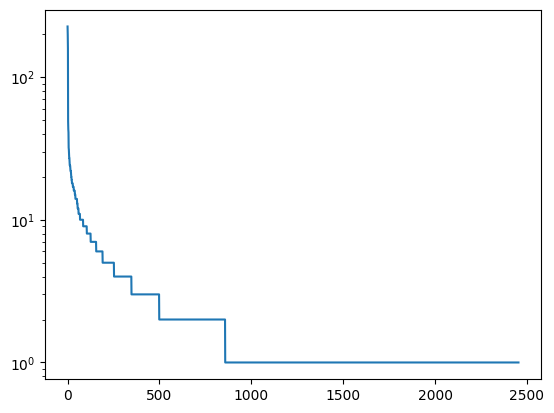

In [ ]:
# Plot the distribution of word occurrences in the 'before' dataset.
plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd_before,axis=1)))
plt.savefig(out_dir+out_file+"_statistics_before.png")

In [ ]:
# Filter out words with low occurrence
select_before = (np.sum(Mwd_before,axis=1)>2)
Mwd_before = Mwd_before[select_before,:]
words_before = words_before[select_before]
# Filter out documents that do not contain words
select_before = (np.sum(Mwd_before,axis=0)>0)
Mwd_before = Mwd_before[:,select_before]
documents_before = documents_before[select_before]
# Display the shape of the final word occurrence matrix after filtering
display(Mwd_before.shape)

(499, 789)

In [ ]:
# Save the result
pickle.dump([Mwd_before,words_before,documents_before], open(out_dir+out_file+"_before_occurrences.p", "wb"))
# c,d,e = pickle.load(open(out_dir+out_file+"_occurrences.p","rb"))

In [ ]:
!pip install bertopic
from bertopic import BERTopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 17.3 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 9.6 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039298 sha256=42f140f6b47c3f28a72d693eaf15970b98f28648f40aecc6364ebcf2c4edd09b
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-

In [ ]:
%run "/content/drive/MyDrive/NetworkScience_Project/Reddit/communities_mod.ipynb"

bertopic 1.11
softlouvain v1.10


In [ ]:
in_dir = "/content/drive/MyDrive/NetworkScience_Project/Reddit/"
in_file = "final_feminism_reddit_before"

# Load the serialized word occurrence data
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Mwd = sps.csr_matrix(Mwd)

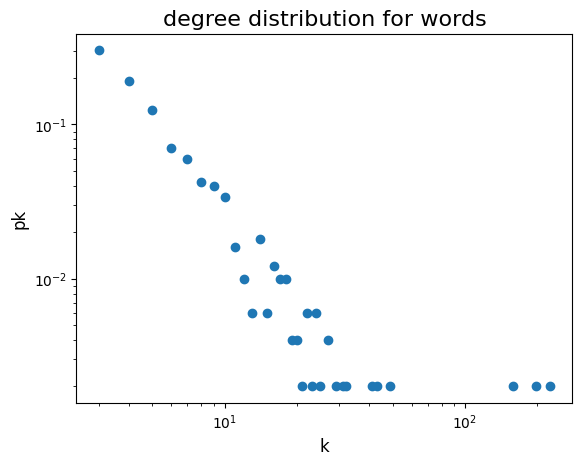

In [ ]:
# Calculate the degree distribution for words within the word occurrence matrix
dw = np.squeeze(np.asarray(Mwd.sum(axis=1))) # words degrees
k = np.unique(dw)
pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(k,pk,'o')
plt.title("degree distribution for words", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

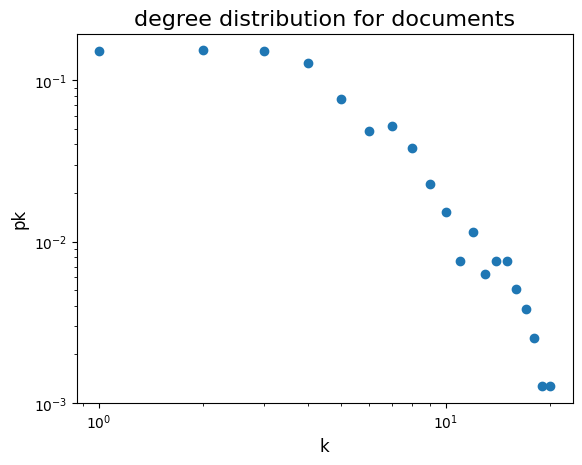

In [ ]:
# Calculate the degree distribution for documents within the word occurrence matrix
dd = np.squeeze(np.asarray(Mwd.sum(axis=0))) # documents degrees
k = np.unique(dd)
pk = np.histogram(dd,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(pk,'o')
plt.title("degree distribution for documents", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

In [ ]:
# Remove elements that are excessively central
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)

removing: feminism NOUN woman NOUN hurt VERB origin NOUN survey NOUN 


In [ ]:
# Construct probability matrices
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

In [ ]:
# Start a timer to measure the execution time
tic = time.time()

# Generate a graph from the document-document probability matrix
A = sps.csr_matrix(Pdd)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

# Apply the Louvain algorithm to the graph for community detection
part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight')

# Define a function to convert the Louvain partitioning result into a community assignment matrix (C)
def partition_to_C(part):
  C = sps.csr_matrix((Pdd.shape[0],len(part)))
  for i in range(len(part)):
    C[np.array(part[i]),i] = 1
  return C

# Convert the Louvain partition into a community assignment matrix
C_l = partition_to_C(part)

# Record the time taken to perform the initial Louvain
et_louv = time.time()-tic

# Apply a refinement step with a 'soft' Louvain algorithm variant
C_sl, _, _ = my_soft_louvain(Pdd, C_l)

# Record the total execution time
et_slouv = time.time()-tic

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[674, 674]
66.46803743153542
25.45584412271572
14.142135623730955
5.656854249492381
1.4142135623730951
0.0
[674, 21]
4.242640687119286
0.0
[674, 20]
0.0


In [ ]:
# Load the cleaned text data
df2 = pd.read_excel(in_dir+in_file+"_cleaned.xlsx")
df2["id"] = np.array([str(i) for i in df2["id"]])

# Filter 'df2' to include only those documents that are present in the community assignment matrix 'Pcc'
documents = np.array([str(i) for i in documents])
df2 = df2.loc[df2['id'].isin(documents)]
df2.index = np.array(range(len(df2)))

# Reinsert hashtags into the cleaned text
df2["text_deep_clean2"] = [str(df2["text_deep_clean"][i]) + " #" +
                           df2["hashtags"][i][2:-2].replace("', '"," #")
                           for i in range(len(df2))]

In [ ]:
# Start a timer to measure the execution time for topic modeling with BERTopic
tic = time.time()

# Initialize a BERTopic instance for topic modeling
bert_model = BERTopic()

# Perform topic modeling on the documents using BERTopic
docs = list(df2["title"])
topics, probabilities = bert_model.fit_transform(docs)

# Define a function to convert the topic assignments into a community assignment matrix
def topics_to_C(topics):
  # extract community assignments
  C = sps.csr_matrix((len(topics),max(topics)+2))
  for i in range(C.shape[1]):
    C[np.array(topics)==(i-1),i] = 1
  # remove zero assignments
  C = C[:,np.unique(scipy.sparse.find(C)[1])]
  return C

# Convert the list of topic assignments into a community assignment
C_b = topics_to_C(topics)

# Calculate and capture the execution time
et_bert = time.time()-tic

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# Initialize a DataFrame
df = pd.DataFrame(data={'data':[],'algo':[],'time':[],'c#':[],
                        'NMI':[],'Q':[],'Ncut':[],'InfoMap':[]})

# Compute the Infomap ranking vector 'r'
r = infomap_rank(Pdd)

In [ ]:
# Evaluate clustering performance metrics for the hard Louvain method
stats = clustering_statistics(C_l,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"hard Louvain Pdd",et_louv,C_l.shape[1]] + stats

# Evaluate clustering performance metrics for the soft Louvain method
stats = clustering_statistics(C_sl,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"soft Louvain Pdd",et_slouv,C_sl.shape[1]] + stats

# Evaluate clustering performance metrics for the hard BERTopic method
stats = clustering_statistics(C_b,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"BERTopic",et_bert,C_b.shape[1]] + stats

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
# Display the result
display(df)

,data,algo,time,c#,NMI,Q,Ncut,InfoMap
0,final_feminism_reddit_before,hard Louvain Pdd,0.257376,21,0.621114,0.449875,0.500561,-0.041171
1,final_feminism_reddit_before,soft Louvain Pdd,4.988620,20,0.619673,0.451275,0.497827,-0.040011
2,final_feminism_reddit_before,BERTopic,42.734140,2,0.734814,0.017107,0.233605,-0.000715


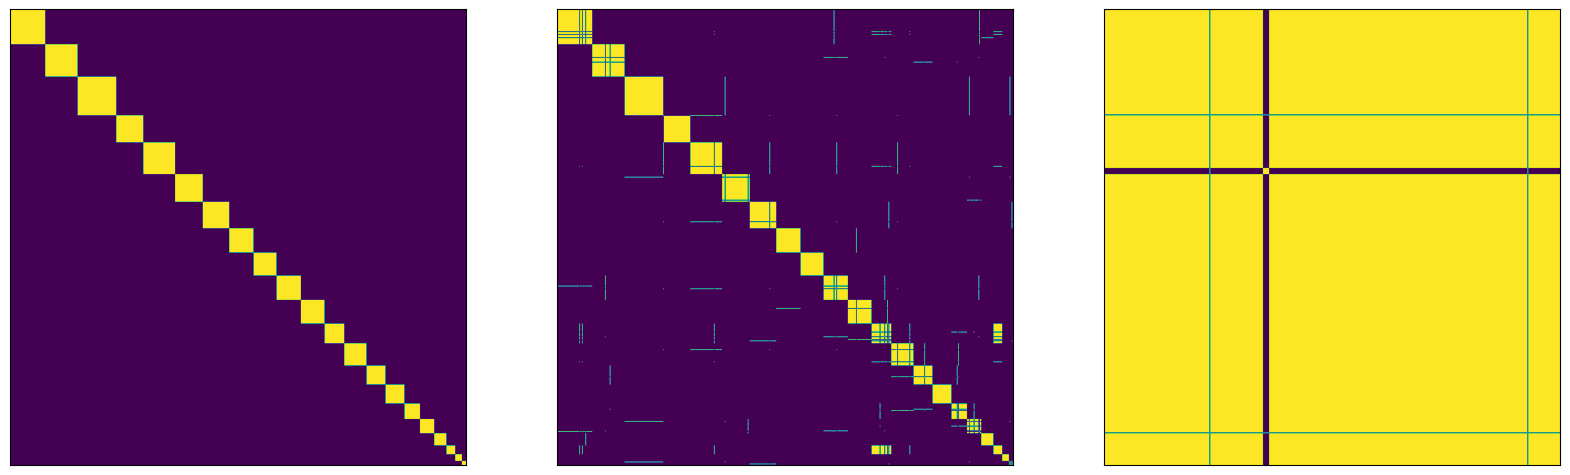

In [ ]:
#  Visualize the community structures
plot_community_patterns([C_l,C_sl,C_b],nrows=1,ncols=3,refs=[0,2])

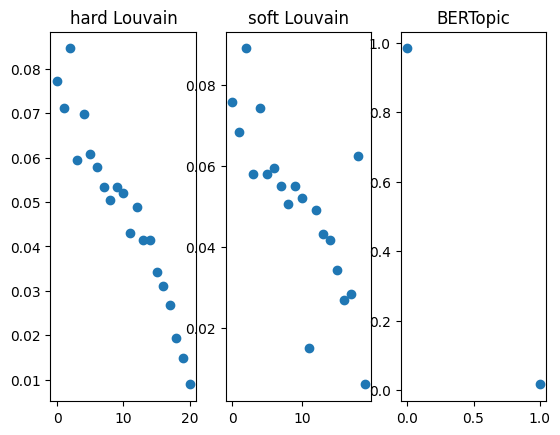

In [ ]:
# visualizes the distribution of documents across communities
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(C_l.sum(axis=0))[0]/C_l.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(C_sl.sum(axis=0))[0]/C_sl.sum(),'o')
ax2.set_title('soft Louvain')
ax3.plot(np.array(C_b.sum(axis=0))[0]/C_b.sum(),'o')
ax3.set_title('BERTopic');

In [ ]:
# Initialize a BERTopic model customized for the communities identified by Louvain
docs = list(df2["text_deep_clean2"])
bert_model1 = bertopic_overwrite(bert_model,docs,C_l)

# Visualize the top words for each topic (community) identified
bert_model1.visualize_barchart(topics = range(C_l.shape[1]),
                               n_words = 8,
                               title = "Louvain results")

In [ ]:
# BERTopic second

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean2"])
bert_model2 = bertopic_overwrite(bert_model,docs,C_b)

# visualize topic description
bert_model2.visualize_barchart(topics = range(C_b.shape[1]),
                               n_words = 8,
                               title = "BERTopic results")

In [ ]:
topics = bert_model1.get_topics()
print(topics)

{0: [('support', 0.09529349562053879), ('need', 0.07127037357374602), ('old', 0.052398745811011956), ('obsession', 0.042961045437979226), ('spread', 0.042961045437979226), ('ignore', 0.042961045437979226), ('complain', 0.04018139776834082), ('aware', 0.04018139776834082), ('stop', 0.04018139776834082), ('woman', 0.03665140613385005)], 1: [('radical', 0.07498053906618232), ('society', 0.06580416670894022), ('country', 0.061010472100755386), ('today', 0.05991410525705023), ('democracy', 0.053289832606079474), ('rise', 0.05084206008396282), ('feminism', 0.04273041738782982), ('hope', 0.042631866084863586), ('work', 0.039648291339512705), ('thought', 0.03902481402459219)], 2: [('abortion', 0.07276957847386599), ('pill', 0.05189187386033166), ('boy', 0.04401494648125004), ('state', 0.04401494648125004), ('allow', 0.041779506779269275), ('right', 0.0412834108173522), ('woman', 0.03455704006905862), ('victim', 0.03354722224377344), ('want', 0.033286886089420875), ('school', 0.0324324211627072

In [ ]:
topics = bert_model1.get_topics()
new_df = pd.DataFrame.from_dict(topics, orient='index')

ktopics = []

for topic_list in range(0, new_df.shape[1]):
  for topic in range(0, new_df.shape[0]):
      ktopics.append(new_df[topic_list][topic][0])

unique_ktopics  = set(ktopics)
topics_ktopics = list(unique_ktopics)

In [ ]:
# Load the CSV file
df = pd.read_excel("drive/MyDrive/NetworkScience_Project/Reddit/final_feminism_reddit_before_cleaned.xlsx")

# Extract all keywords from the BERT model's output
keywords = topics_ktopics

df["hashtags_2"] = None
for i in range(len(df["text_deep_clean"])):
  if isinstance(df["text_deep_clean"][i], str):  # Check if text is a string
    hashtags2 = []

    for word in df["text_deep_clean"][i].split():

      if word in keywords:
        #  print(type(word))
          hashtags2.append(str(word))
          df["hashtags_2"][i] = hashtags2

In [ ]:
df.to_pickle('drive/MyDrive/NetworkScience_Project/Reddit/final_feminism_reddit_before_cleaned.pkl')

In [ ]:
comments_df = pd.read_pickle("drive/MyDrive/NetworkScience_Project/Reddit/final_feminism_reddit_before_cleaned.pkl")

In [ ]:
comments_filtered = comments_df.copy()
column_list = ["id","created", "text_deep_clean", "text_deep_clean_pos", "hashtags_2"]
comments_filtered = comments_filtered[column_list]

In [ ]:
#initialize an empty dict
unique_words = {}
for row in comments_filtered["text_deep_clean"]:
    if pd.notna(row):
        # Split the row into words and iterate over them
        for word in row.split(" "):
            #if the word is encountered for the first time add to dict as key and set its value to 0
            unique_words.setdefault(word,0)
            #increase the value (i.e the count) of the word by 1 every time it is encountered
            unique_words[word] += 1

In [ ]:
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df

,Word,Count
4,feminism,230
54,woman,200
16,man,159
0,feminist,95
79,right,42
...,...,...
1080,accuse,1
1078,ro,1
1077,unfortunately,1
1076,campaign,1


In [ ]:
unique_hashtags = {}


for idx, row in comments_filtered.iterrows():
  hashtag_list = []
  try:
    for hashtag in row["hashtags_2"]:
      unique_hashtags.setdefault("#"+hashtag, 0)
      unique_hashtags['#'+hashtag] += 1
      hashtag_list.append(hashtag)
  except:
      continue

In [ ]:
uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
uh_df.sort_values(by=['Count'], ascending=False, inplace=True)

*Network* Building

In [ ]:
import itertools
import networkx as nx

In [ ]:
uh = unique_hashtags.keys()
uw = unique_words.keys()

In [ ]:
import numpy as np
network = {}
for index, row in comments_filtered.iterrows():
    combined_list = row['hashtags_2']  # Use keys() to get the list of unique subreddits
    if isinstance(combined_list, list):
      for pair in itertools.product(combined_list, combined_list):
          if pair[0] != pair[1] and not (pair[::-1] in network):
              #breakpoint()
              network.setdefault(pair, 0)
              # Update the weight based on actual occurrences
              network[pair] += 1

network_df = pd.DataFrame.from_dict(network, orient="index")

In [ ]:
network_df.reset_index(inplace=True)
network_df.columns = ["pair","weight"]
network_df.sort_values(by="weight",inplace=True, ascending=False)
network_df

,pair,weight
25,"(woman, man)",80
55,"(feminism, woman)",51
8,"(feminism, man)",37
161,"(feminist, man)",32
79,"(woman, feminist)",25
...,...,...
622,"(equality, boy)",1
623,"(example, boy)",1
629,"(feminism, opinion)",1
630,"(opinion, misogyny)",1


In [ ]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0],edge[1],network[edge]))

G = nx.Graph()
G.add_weighted_edges_from(up_weighted)

In [ ]:
print(len(G.nodes()))
print(len(G.edges()))

197
1349


In [ ]:
filename = "drive/MyDrive/NetworkScience_Project/Reddit/feminism_edgelist_before_released.csv"

In [ ]:
nx.write_weighted_edgelist(G, filename, delimiter=",")

In [ ]:
word_nodes = pd.DataFrame.from_dict(unique_words,orient="index")
word_nodes.reset_index(inplace=True)
word_nodes["Label"] = word_nodes["index"]
word_nodes.rename(columns={"index":"Id",0:"delete"},inplace=True)
word_nodes = word_nodes.drop(columns=['delete'])

In [ ]:
hashtag_nodes = uh_df.copy()
hashtag_nodes["Label"] = hashtag_nodes["Hashtag"]
hashtag_nodes.rename(columns={"Hashtag":"Id"},inplace=True)
hashtag_nodes = hashtag_nodes.drop(columns=['Count'])

In [ ]:
nodelist = hashtag_nodes
nodelist.to_csv("drive/MyDrive/NetworkScience_Project/Reddit/feminism_nodelist_before_released.csv",index=False)

In [ ]:
a = pd.read_csv("drive/MyDrive/NetworkScience_Project/Reddit/feminism_edgelist_before_released.csv")

In [ ]:
a.columns = ['Source','Target','Label']

In [ ]:
a.to_csv("drive/MyDrive/NetworkScience_Project/Reddit/feminism_edgelist_before_released.csv",index=False)